In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 24.4 MB/s eta 0:00:00


In [ ]:
#Training 2 degree images using MSE, MAE[L1 loss] loss functions
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import torchmetrics

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# SSIM loss function
ssim_loss_fn = torchmetrics.functional.structural_similarity_index_measure

# Training Function
def train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            ssim_loss = 1 - ssim_loss_fn(refined_image, ground_truths)
            artifact_loss = criterion_art(artifact, inputs - ground_truths)
            refinement_loss = criterion_mask(refined_image, ground_truths)
            loss = artifact_loss + refinement_loss + ssim_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            artifact, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/2_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/MSE, MAE loss functions/today 2 degree output'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion_art = nn.MSELoss()
    criterion_mask = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/20], Loss: 3.0633
Epoch [2/20], Loss: 3.0163
Epoch [3/20], Loss: 2.9886
Epoch [4/20], Loss: 2.9576
Epoch [5/20], Loss: 2.9332
Epoch [6/20], Loss: 2.9034
Epoch [7/20], Loss: 2.8897
Epoch [8/20], Loss: 2.8706
Epoch [9/20], Loss: 2.8493
Epoch [10/20], Loss: 2.8419
Epoch [11/20], Loss: 2.8237
Epoch [12/20], Loss: 2.8020
Epoch [13/20], Loss: 2.7936
Epoch [14/20], Loss: 2.7715
Epoch [15/20], Loss: 2.7681
Epoch [16/20], Loss: 2.7504
Epoch [17/20], Loss: 2.7458
Epoch [18/20], Loss: 2.7312
Epoch [19/20], Loss: 2.7174
Epoch [20/20], Loss: 2.7048
Saved predicted image /content/drive/MyDrive/MSE, MAE loss functions/today 2 degree output/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/MSE, MAE loss functions/today 2 degree output/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/MSE, MAE loss functions/today 2 degree output/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/MSE, MAE loss functions/today 2 degree output/predicted_4.jpg
Saved predicted image

In [ ]:
#Training 3 degree images using MSE, MAE[L1 loss] loss functions
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import torchmetrics

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# SSIM loss function
ssim_loss_fn = torchmetrics.functional.structural_similarity_index_measure

# Training Function
def train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            ssim_loss = 1 - ssim_loss_fn(refined_image, ground_truths)
            artifact_loss = criterion_art(artifact, inputs - ground_truths)
            refinement_loss = criterion_mask(refined_image, ground_truths)
            loss = artifact_loss + refinement_loss + ssim_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            artifact, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/3_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/today 3 degree output'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion_art = nn.MSELoss()
    criterion_mask = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/20], Loss: 3.0447
Epoch [2/20], Loss: 3.0167
Epoch [3/20], Loss: 2.9826
Epoch [4/20], Loss: 2.9461
Epoch [5/20], Loss: 2.9100
Epoch [6/20], Loss: 2.8788
Epoch [7/20], Loss: 2.8474
Epoch [8/20], Loss: 2.8121
Epoch [9/20], Loss: 2.7911
Epoch [10/20], Loss: 2.7763
Epoch [11/20], Loss: 2.7561
Epoch [12/20], Loss: 2.7406
Epoch [13/20], Loss: 2.7315
Epoch [14/20], Loss: 2.7230
Epoch [15/20], Loss: 2.7131
Epoch [16/20], Loss: 2.7007
Epoch [17/20], Loss: 2.6910
Epoch [18/20], Loss: 2.6825
Epoch [19/20], Loss: 2.6749
Epoch [20/20], Loss: 2.6707
Saved predicted image /content/drive/MyDrive/today 3 degree output/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/today 3 degree output/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/today 3 degree output/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/today 3 degree output/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/today 3 degree output/predicted_5.jpg
Saved predicted image /content/dri

In [ ]:
#Training 4 degree images using MSE, MAE[L1 loss] loss functions
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import torchmetrics

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# SSIM loss function
ssim_loss_fn = torchmetrics.functional.structural_similarity_index_measure

# Training Function
def train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            ssim_loss = 1 - ssim_loss_fn(refined_image, ground_truths)
            artifact_loss = criterion_art(artifact, inputs - ground_truths)
            refinement_loss = criterion_mask(refined_image, ground_truths)
            loss = artifact_loss + refinement_loss + ssim_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            artifact, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/4_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/today 4 degree output'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion_art = nn.MSELoss()
    criterion_mask = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/20], Loss: 2.6041
Epoch [2/20], Loss: 2.5784
Epoch [3/20], Loss: 2.5510
Epoch [4/20], Loss: 2.5284
Epoch [5/20], Loss: 2.5061
Epoch [6/20], Loss: 2.4874
Epoch [7/20], Loss: 2.4625
Epoch [8/20], Loss: 2.4496
Epoch [9/20], Loss: 2.4240
Epoch [10/20], Loss: 2.4104
Epoch [11/20], Loss: 2.3956
Epoch [12/20], Loss: 2.3843
Epoch [13/20], Loss: 2.3720
Epoch [14/20], Loss: 2.3604
Epoch [15/20], Loss: 2.3465
Epoch [16/20], Loss: 2.3387
Epoch [17/20], Loss: 2.3262
Epoch [18/20], Loss: 2.3162
Epoch [19/20], Loss: 2.3154
Epoch [20/20], Loss: 2.2982
Saved predicted image /content/drive/MyDrive/today 4 degree output/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/today 4 degree output/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/today 4 degree output/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/today 4 degree output/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/today 4 degree output/predicted_5.jpg
Saved predicted image /content/dri

In [ ]:
#Training 5 degree images using MSE, MAE[L1 loss] loss functions
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import torchmetrics

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# SSIM loss function
ssim_loss_fn = torchmetrics.functional.structural_similarity_index_measure

# Training Function
def train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            ssim_loss = 1 - ssim_loss_fn(refined_image, ground_truths)
            artifact_loss = criterion_art(artifact, inputs - ground_truths)
            refinement_loss = criterion_mask(refined_image, ground_truths)
            loss = artifact_loss + refinement_loss + ssim_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            artifact, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/5_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/today 5 degree output'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion_art = nn.MSELoss()
    criterion_mask = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion_art, criterion_mask, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 3.2384
Epoch [2/20], Loss: 3.2070
Epoch [3/20], Loss: 3.1757
Epoch [4/20], Loss: 3.1553
Epoch [5/20], Loss: 3.1341
Epoch [6/20], Loss: 3.1135
Epoch [7/20], Loss: 3.0943
Epoch [8/20], Loss: 3.0682
Epoch [9/20], Loss: 3.0518
Epoch [10/20], Loss: 3.0454
Epoch [11/20], Loss: 3.0287
Epoch [12/20], Loss: 3.0083
Epoch [13/20], Loss: 3.0073
Epoch [14/20], Loss: 2.9828
Epoch [15/20], Loss: 2.9749
Epoch [16/20], Loss: 2.9659
Epoch [17/20], Loss: 2.9517
Epoch [18/20], Loss: 2.9403
Epoch [19/20], Loss: 2.9354
Epoch [20/20], Loss: 2.9209
Saved predicted image /content/drive/MyDrive/today 5 degree output/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/today 5 degree output/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/today 5 degree output/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/today 5 degree output/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/today 5 degree output/predicted_5.jpg
Saved predicted image /content/dri

In [ ]:
#Training 2 degree using only mse loss function
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            loss = criterion(refined_image, ground_truths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            _, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/2_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/MSE/2degree'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 1.6181
Epoch [2/20], Loss: 1.5540
Epoch [3/20], Loss: 1.5321
Epoch [4/20], Loss: 1.4583
Epoch [5/20], Loss: 1.4359
Epoch [6/20], Loss: 1.3898
Epoch [7/20], Loss: 1.3197
Epoch [8/20], Loss: 1.2864
Epoch [9/20], Loss: 1.2685
Epoch [10/20], Loss: 1.2527
Epoch [11/20], Loss: 1.2481
Epoch [12/20], Loss: 1.2213
Epoch [13/20], Loss: 1.2137
Epoch [14/20], Loss: 1.1973
Epoch [15/20], Loss: 1.1784
Epoch [16/20], Loss: 1.1713
Epoch [17/20], Loss: 1.1646
Epoch [18/20], Loss: 1.1677
Epoch [19/20], Loss: 1.1551
Epoch [20/20], Loss: 1.1503
Saved predicted image /content/drive/MyDrive/MSE/2degree/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/MSE/2degree/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/MSE/2degree/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/MSE/2degree/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/MSE/2degree/predicted_5.jpg
Saved predicted image /content/drive/MyDrive/MSE/2degree/predicted_6.jpg
Saved predi

In [ ]:
#Training 3 degree using only mse loss function
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            loss = criterion(refined_image, ground_truths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            _, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/3_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/MSE/3degree'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 1.3440
Epoch [2/20], Loss: 1.3179
Epoch [3/20], Loss: 1.2884
Epoch [4/20], Loss: 1.2724
Epoch [5/20], Loss: 1.2545
Epoch [6/20], Loss: 1.2454
Epoch [7/20], Loss: 1.2183
Epoch [8/20], Loss: 1.2063
Epoch [9/20], Loss: 1.1873
Epoch [10/20], Loss: 1.1693
Epoch [11/20], Loss: 1.1562
Epoch [12/20], Loss: 1.1553
Epoch [13/20], Loss: 1.1491
Epoch [14/20], Loss: 1.1353
Epoch [15/20], Loss: 1.1058
Epoch [16/20], Loss: 1.1106
Epoch [17/20], Loss: 1.0990
Epoch [18/20], Loss: 1.0806
Epoch [19/20], Loss: 1.0841
Epoch [20/20], Loss: 1.0689
Saved predicted image /content/drive/MyDrive/MSE/3degree/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/MSE/3degree/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/MSE/3degree/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/MSE/3degree/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/MSE/3degree/predicted_5.jpg
Saved predicted image /content/drive/MyDrive/MSE/3degree/predicted_6.jpg
Saved predi

In [ ]:
#Training 4 degree using only mse loss function
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            loss = criterion(refined_image, ground_truths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            _, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/4_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/MSE/4degree'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 1.3148
Epoch [2/20], Loss: 1.2888
Epoch [3/20], Loss: 1.2627
Epoch [4/20], Loss: 1.2187
Epoch [5/20], Loss: 1.1935
Epoch [6/20], Loss: 1.1656
Epoch [7/20], Loss: 1.1341
Epoch [8/20], Loss: 1.1054
Epoch [9/20], Loss: 1.0976
Epoch [10/20], Loss: 1.0814
Epoch [11/20], Loss: 1.0479
Epoch [12/20], Loss: 1.0558
Epoch [13/20], Loss: 1.0277
Epoch [14/20], Loss: 1.0221
Epoch [15/20], Loss: 0.9996
Epoch [16/20], Loss: 0.9872
Epoch [17/20], Loss: 0.9873
Epoch [18/20], Loss: 0.9749
Epoch [19/20], Loss: 0.9657
Epoch [20/20], Loss: 0.9619
Saved predicted image /content/drive/MyDrive/MSE/4degree/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/MSE/4degree/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/MSE/4degree/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/MSE/4degree/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/MSE/4degree/predicted_5.jpg
Saved predicted image /content/drive/MyDrive/MSE/4degree/predicted_6.jpg
Saved predi

In [ ]:
#Training 5 degree using only mse loss function
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import numpy as np

# Fourier Transform Utilities
def real_fourier_transform(img):
    return torch.fft.fft2(img, dim=(-2, -1)).real

def inverse_fourier_transform(fourier_img):
    return torch.fft.ifft2(fourier_img, dim=(-2, -1)).real

# Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

# FreeNet Architecture
class FreeNet(nn.Module):
    def __init__(self):
        super(FreeNet, self).__init__()
        self.bandpass_conv = ConvBlock(1, 16, kernel_size=1)
        self.fourier_conv1 = ConvBlock(16, 32, kernel_size=3)
        self.fourier_conv2 = ConvBlock(32, 64, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        bandpass = self.bandpass_conv(x)
        freq = real_fourier_transform(bandpass).unsqueeze(1)
        if len(freq.shape) > 4:
            freq = freq.squeeze(1)
        filtered_freq = self.fourier_conv1(freq)
        filtered_freq = self.fourier_conv2(filtered_freq)
        artifact = self.final_conv(filtered_freq)
        return artifact

# SeedNet Architecture
class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = ConvBlock(1, 16, kernel_size=3)
        self.conv2 = ConvBlock(16, 32, kernel_size=3)
        self.conv3 = ConvBlock(32, 16, kernel_size=3)
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        refined_img = self.final_conv(x)
        return refined_img

# FreeSeed Model
class FreeSeed(nn.Module):
    def __init__(self):
        super(FreeSeed, self).__init__()
        self.freenet = FreeNet()
        self.seednet = SeedNet()

    def forward(self, sparse_view):
        artifact = self.freenet(sparse_view)
        refined_image = self.seednet(sparse_view - artifact)
        return artifact, refined_image

# Custom Dataset
class CTDataset(Dataset):
    def __init__(self, input_dir, ground_truth_dir, transform=None):
        input_files = {f: os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')}
        gt_files = {f: os.path.join(ground_truth_dir, f) for f in os.listdir(ground_truth_dir) if f.endswith('.jpg')}

        # Match input files with ground truth files by filename
        self.image_pairs = [(input_files[f], gt_files[f]) for f in input_files if f in gt_files]

        if len(self.image_pairs) == 0:
            raise ValueError("No matching filenames found between input and ground truth directories!")

        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_path, ground_truth_path = self.image_pairs[idx]
        input_img = Image.open(input_path).convert('L')
        ground_truth_img = Image.open(ground_truth_path).convert('L')
        if self.transform:
            input_img = self.transform(input_img)
            ground_truth_img = self.transform(ground_truth_img)
        return input_img, ground_truth_img

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.apply(initialize_weights)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, ground_truths in dataloader:
            inputs, ground_truths = inputs.to(device), ground_truths.to(device)
            artifact, refined_image = model(inputs)
            loss = criterion(refined_image, ground_truths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

# Save Model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Inference Function
def predict_and_save(model, input_dir, output_dir, transform, device):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    input_images = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
    with torch.no_grad():
        for idx, input_img_path in enumerate(input_images):
            input_img = Image.open(input_img_path).convert('L')
            input_img = transform(input_img).unsqueeze(0).to(device)
            _, refined_image = model(input_img)
            refined_image = refined_image.squeeze()
            refined_image = (refined_image - refined_image.min()) / (refined_image.max() - refined_image.min())
            refined_image = (refined_image * 255).cpu().numpy().astype(np.uint8)
            refined_image_pil = Image.fromarray(refined_image)
            output_img_path = os.path.join(output_dir, f"predicted_{idx+1}.jpg")
            refined_image_pil.save(output_img_path)
            print(f"Saved predicted image {output_img_path}")

# Main Function
def main():
    input_dir = '/content/drive/MyDrive/today/5_degree'
    ground_truth_dir = '/content/drive/MyDrive/review'
    model_save_dir = '/path/to/model_save_dir'
    os.makedirs(model_save_dir, exist_ok=True)
    model_save_path = os.path.join(model_save_dir, 'model.pth')
    output_dir = '/content/drive/MyDrive/MSE/5degree'
    batch_size = 4
    num_epochs = 20
    learning_rate = 0.0001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = CTDataset(input_dir, ground_truth_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = FreeSeed()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = train_model(model, dataloader, criterion, optimizer, num_epochs, device)
    save_model(model, model_save_path)
    predict_and_save(model, input_dir, output_dir, transform, device)

if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 1.3579
Epoch [2/20], Loss: 1.3176
Epoch [3/20], Loss: 1.3038
Epoch [4/20], Loss: 1.2607
Epoch [5/20], Loss: 1.2356
Epoch [6/20], Loss: 1.2039
Epoch [7/20], Loss: 1.1762
Epoch [8/20], Loss: 1.1481
Epoch [9/20], Loss: 1.1177
Epoch [10/20], Loss: 1.1147
Epoch [11/20], Loss: 1.0864
Epoch [12/20], Loss: 1.0634
Epoch [13/20], Loss: 1.0628
Epoch [14/20], Loss: 1.0395
Epoch [15/20], Loss: 1.0275
Epoch [16/20], Loss: 1.0176
Epoch [17/20], Loss: 1.0077
Epoch [18/20], Loss: 1.0017
Epoch [19/20], Loss: 0.9838
Epoch [20/20], Loss: 0.9830
Saved predicted image /content/drive/MyDrive/MSE/5degree/predicted_1.jpg
Saved predicted image /content/drive/MyDrive/MSE/5degree/predicted_2.jpg
Saved predicted image /content/drive/MyDrive/MSE/5degree/predicted_3.jpg
Saved predicted image /content/drive/MyDrive/MSE/5degree/predicted_4.jpg
Saved predicted image /content/drive/MyDrive/MSE/5degree/predicted_5.jpg
Saved predicted image /content/drive/MyDrive/MSE/5degree/predicted_6.jpg
Saved predi

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/1.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/today output/predicted_1.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.922868794983952 dB


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/today output/predicted_10.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.81698718469321 dB


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/today 3 degree output/predicted_10.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.776049907109194 dB


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/MSE, MAE loss functions/today 4 degree output/predicted_10.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.9024115150419 dB


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/MSE, MAE loss functions/today 5 degree output/predicted_10.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.925125522280187 dB


In [ ]:
import cv2
import numpy as np

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

# Example usage
# Provide the image path and masks for the two regions
image_path = "/content/drive/MyDrive/today output/predicted_10.jpg"  # Replace with your .jpg file path

# Define binary masks for the two regions (manually or using a tool like OpenCV)
# Example: region1_mask and region2_mask should be boolean arrays of the same size as the image
region1_mask = np.zeros((512, 512), dtype=bool)  # Replace with your mask for region 1
region2_mask = np.zeros((512, 512), dtype=bool)  # Replace with your mask for region 2

# Example: Manually set pixels for demonstration (adjust as per your regions)
region1_mask[100:150, 100:150] = True  # Define a region of interest
region2_mask[300:350, 300:350] = True  # Define a background region

# Compute CNR
try:
    cnr = calculate_cnr(image_path, region1_mask, region2_mask)
    print(f"CNR: {cnr}")
except ValueError as e:
    print(e)


CNR: 0.49163041903740146


In [ ]:
import cv2
import numpy as np

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

# Example usage
# Provide the image path and masks for the two regions
image_path = "/content/drive/MyDrive/today 3 degree output/predicted_10.jpg"  # Replace with your .jpg file path

# Define binary masks for the two regions (manually or using a tool like OpenCV)
# Example: region1_mask and region2_mask should be boolean arrays of the same size as the image
region1_mask = np.zeros((512, 512), dtype=bool)  # Replace with your mask for region 1
region2_mask = np.zeros((512, 512), dtype=bool)  # Replace with your mask for region 2

# Example: Manually set pixels for demonstration (adjust as per your regions)
region1_mask[100:150, 100:150] = True  # Define a region of interest
region2_mask[300:350, 300:350] = True  # Define a background region

# Compute CNR
try:
    cnr = calculate_cnr(image_path, region1_mask, region2_mask)
    print(f"CNR: {cnr}")
except ValueError as e:
    print(e)


CNR: 1.111233097270181


In [ ]:
import cv2
import numpy as np
import os

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image {image_path} could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

def calculate_cnr_for_folder(folder_path, region1_mask, region2_mask):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            # Compute CNR for each image
            cnr = calculate_cnr(image_path, region1_mask, region2_mask)
            results[image_file] = cnr
        except ValueError as e:
            print(e)
            results[image_file] = None

    return results

# Example usage
folder_path = "/content/drive/MyDrive/MSE, MAE loss functions/today 4 degree output"  # Replace with your folder path

# Define binary masks for the two regions
# Note: Masks should be of the same size as the images
# Example: Adjust the mask regions as per your requirement
image_shape = (512, 512)  # Replace with the shape of your images
region1_mask = np.zeros(image_shape, dtype=bool)
region2_mask = np.zeros(image_shape, dtype=bool)

# Define regions for masks
region1_mask[100:150, 100:150] = True  # Region 1
region2_mask[300:350, 300:350] = True  # Region 2

# Compute CNR for all images in the folder
cnr_results = calculate_cnr_for_folder(folder_path, region1_mask, region2_mask)

# Print results
for image_file, cnr in cnr_results.items():
    print(f"{image_file}: {cnr}")


predicted_1.jpg: 0.7567365997897886
predicted_2.jpg: 0.08813462109251663
predicted_3.jpg: 0.9880226520043803
predicted_4.jpg: 1.4468787207892764
predicted_5.jpg: 1.3188334370423747
predicted_6.jpg: 1.268544470185913
predicted_7.jpg: 1.2505333229914284
predicted_8.jpg: 1.0652631064543283
predicted_9.jpg: 0.9347197535667683
predicted_10.jpg: 0.5653067636983855


In [ ]:
import cv2
import numpy as np
import os

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image {image_path} could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

def calculate_cnr_for_folder(folder_path, region1_mask, region2_mask):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            # Compute CNR for each image
            cnr = calculate_cnr(image_path, region1_mask, region2_mask)
            results[image_file] = cnr
        except ValueError as e:
            print(e)
            results[image_file] = None

    return results

# Example usage
folder_path = "/content/drive/MyDrive/MSE, MAE loss functions/today 5 degree output"  # Replace with your folder path

# Define binary masks for the two regions
# Note: Masks should be of the same size as the images
# Example: Adjust the mask regions as per your requirement
image_shape = (512, 512)  # Replace with the shape of your images
region1_mask = np.zeros(image_shape, dtype=bool)
region2_mask = np.zeros(image_shape, dtype=bool)

# Define regions for masks
region1_mask[100:150, 100:150] = True  # Region 1
region2_mask[300:350, 300:350] = True  # Region 2

# Compute CNR for all images in the folder
cnr_results = calculate_cnr_for_folder(folder_path, region1_mask, region2_mask)

# Print results
for image_file, cnr in cnr_results.items():
    print(f"{image_file}: {cnr}")


predicted_1.jpg: 1.292877383033884
predicted_2.jpg: 0.3140358402935632
predicted_3.jpg: 2.415773212049892
predicted_4.jpg: 1.6737896058622672
predicted_5.jpg: 1.5451768954098364
predicted_6.jpg: 1.984788735727283
predicted_7.jpg: 1.8835170854897676
predicted_8.jpg: 1.8564848294456984
predicted_9.jpg: 1.2731338612297944
predicted_10.jpg: 0.7332182836477837


In [ ]:
import cv2
import numpy as np
import os

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image {image_path} could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

def calculate_cnr_for_folder(folder_path, region1_mask, region2_mask):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            # Compute CNR for each image
            cnr = calculate_cnr(image_path, region1_mask, region2_mask)
            results[image_file] = cnr
        except ValueError as e:
            print(e)
            results[image_file] = None

    return results

# Example usage
folder_path = "/content/drive/MyDrive/MSE/2degree"  # Replace with your folder path

# Define binary masks for the two regions
# Note: Masks should be of the same size as the images
# Example: Adjust the mask regions as per your requirement
image_shape = (512, 512)  # Replace with the shape of your images
region1_mask = np.zeros(image_shape, dtype=bool)
region2_mask = np.zeros(image_shape, dtype=bool)

# Define regions for masks
region1_mask[100:150, 100:150] = True  # Region 1
region2_mask[300:350, 300:350] = True  # Region 2

# Compute CNR for all images in the folder
cnr_results = calculate_cnr_for_folder(folder_path, region1_mask, region2_mask)

# Print results
for image_file, cnr in cnr_results.items():
    print(f"{image_file}: {cnr}")


predicted_1.jpg: 2.2454793517967393
predicted_2.jpg: 0.7524220842500399
predicted_3.jpg: 3.4275479051510267
predicted_4.jpg: 3.976535992005485
predicted_5.jpg: 3.3332097724107377
predicted_6.jpg: 3.4750071894591095
predicted_7.jpg: 3.5894484943606324
predicted_8.jpg: 2.78960304238293
predicted_9.jpg: 1.847260087023776
predicted_10.jpg: 1.2144654997854751


In [ ]:
import cv2
import numpy as np
import os

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image {image_path} could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

def calculate_cnr_for_folder(folder_path, region1_mask, region2_mask):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            # Compute CNR for each image
            cnr = calculate_cnr(image_path, region1_mask, region2_mask)
            results[image_file] = cnr
        except ValueError as e:
            print(e)
            results[image_file] = None

    return results

# Example usage
folder_path = "/content/drive/MyDrive/MSE/3degree"  # Replace with your folder path

# Define binary masks for the two regions
# Note: Masks should be of the same size as the images
# Example: Adjust the mask regions as per your requirement
image_shape = (512, 512)  # Replace with the shape of your images
region1_mask = np.zeros(image_shape, dtype=bool)
region2_mask = np.zeros(image_shape, dtype=bool)

# Define regions for masks
region1_mask[100:150, 100:150] = True  # Region 1
region2_mask[300:350, 300:350] = True  # Region 2

# Compute CNR for all images in the folder
cnr_results = calculate_cnr_for_folder(folder_path, region1_mask, region2_mask)

# Print results
for image_file, cnr in cnr_results.items():
    print(f"{image_file}: {cnr}")


predicted_1.jpg: 1.6104702159465323
predicted_2.jpg: 0.5400277467424607
predicted_3.jpg: 2.661691336499916
predicted_4.jpg: 2.8176082515431022
predicted_5.jpg: 2.7348531014178175
predicted_6.jpg: 2.559963833645964
predicted_7.jpg: 2.6638176924583394
predicted_8.jpg: 2.3965362715172702
predicted_9.jpg: 1.5241679044986711
predicted_10.jpg: 0.9577855610000959


In [ ]:
import cv2
import numpy as np
import os

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image {image_path} could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

def calculate_cnr_for_folder(folder_path, region1_mask, region2_mask):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            # Compute CNR for each image
            cnr = calculate_cnr(image_path, region1_mask, region2_mask)
            results[image_file] = cnr
        except ValueError as e:
            print(e)
            results[image_file] = None

    return results

# Example usage
folder_path = "/content/drive/MyDrive/MSE/4degree"  # Replace with your folder path

# Define binary masks for the two regions
# Note: Masks should be of the same size as the images
# Example: Adjust the mask regions as per your requirement
image_shape = (512, 512)  # Replace with the shape of your images
region1_mask = np.zeros(image_shape, dtype=bool)
region2_mask = np.zeros(image_shape, dtype=bool)

# Define regions for masks
region1_mask[100:150, 100:150] = True  # Region 1
region2_mask[300:350, 300:350] = True  # Region 2

# Compute CNR for all images in the folder
cnr_results = calculate_cnr_for_folder(folder_path, region1_mask, region2_mask)

# Print results
for image_file, cnr in cnr_results.items():
    print(f"{image_file}: {cnr}")


predicted_1.jpg: 3.1482647108377506
predicted_2.jpg: 0.9859622175143267
predicted_3.jpg: 3.814486517362403
predicted_4.jpg: 4.100156302529602
predicted_5.jpg: 3.260293555430555
predicted_6.jpg: 3.5196872337787903
predicted_7.jpg: 3.6801458688400515
predicted_8.jpg: 3.168866000221545
predicted_9.jpg: 2.2608489068810202
predicted_10.jpg: 1.5212197202944435


In [ ]:
import cv2
import numpy as np
import os

def calculate_cnr(image_path, region1_mask, region2_mask):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image {image_path} could not be loaded. Please check the path.")

    # Extract pixel values for the two regions based on masks
    region1_pixels = image[region1_mask]
    region2_pixels = image[region2_mask]

    # Compute mean and variance for the two regions
    mu_p = np.mean(region1_pixels)
    mu_g = np.mean(region2_pixels)
    sigma_p2 = np.var(region1_pixels)
    sigma_g2 = np.var(region2_pixels)

    # Calculate CNR
    cnr = abs(mu_p - mu_g) / np.sqrt(sigma_p2 + sigma_g2)
    return cnr

def calculate_cnr_for_folder(folder_path, region1_mask, region2_mask):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            # Compute CNR for each image
            cnr = calculate_cnr(image_path, region1_mask, region2_mask)
            results[image_file] = cnr
        except ValueError as e:
            print(e)
            results[image_file] = None

    return results

# Example usage
folder_path = "/content/drive/MyDrive/MSE/5degree"  # Replace with your folder path

# Define binary masks for the two regions
# Note: Masks should be of the same size as the images
# Example: Adjust the mask regions as per your requirement
image_shape = (512, 512)  # Replace with the shape of your images
region1_mask = np.zeros(image_shape, dtype=bool)
region2_mask = np.zeros(image_shape, dtype=bool)

# Define regions for masks
region1_mask[100:150, 100:150] = True  # Region 1
region2_mask[300:350, 300:350] = True  # Region 2

# Compute CNR for all images in the folder
cnr_results = calculate_cnr_for_folder(folder_path, region1_mask, region2_mask)

# Print results
for image_file, cnr in cnr_results.items():
    print(f"{image_file}: {cnr}")


predicted_1.jpg: 1.6567017500711996
predicted_2.jpg: 0.4857552711135015
predicted_3.jpg: 3.2966956399530067
predicted_4.jpg: 2.578696477408894
predicted_5.jpg: 2.2646677703365503
predicted_6.jpg: 2.7036761628699644
predicted_7.jpg: 2.6833317149666054
predicted_8.jpg: 2.3632741088619076
predicted_9.jpg: 1.5161980572627052
predicted_10.jpg: 0.8883791447669691


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/2.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/today output/predicted_2.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.9957804660854865


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/1.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/today output/predicted_1.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.996259431527825


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/today output/predicted_10.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.9954588513121271


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/today 3 degree output/predicted_10.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.9971521507214167


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/MSE/5degree/predicted_10.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.9978853897722019


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/2.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/MSE, MAE loss functions/today 2 degree output/predicted_2.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.9909314642110106


In [ ]:
pip install opencv-python numpy


Method               Base-Base  Base-Half  Base-Test1 Base-Test2
Correlation          1.0        1.0        1.0        1.0       
Chi-Square           0.0        0.0        0.0        0.0       
Intersection         1.0        1.0        1.0        1.0       
Bhattacharyya        0.0        0.0        0.0        0.0       


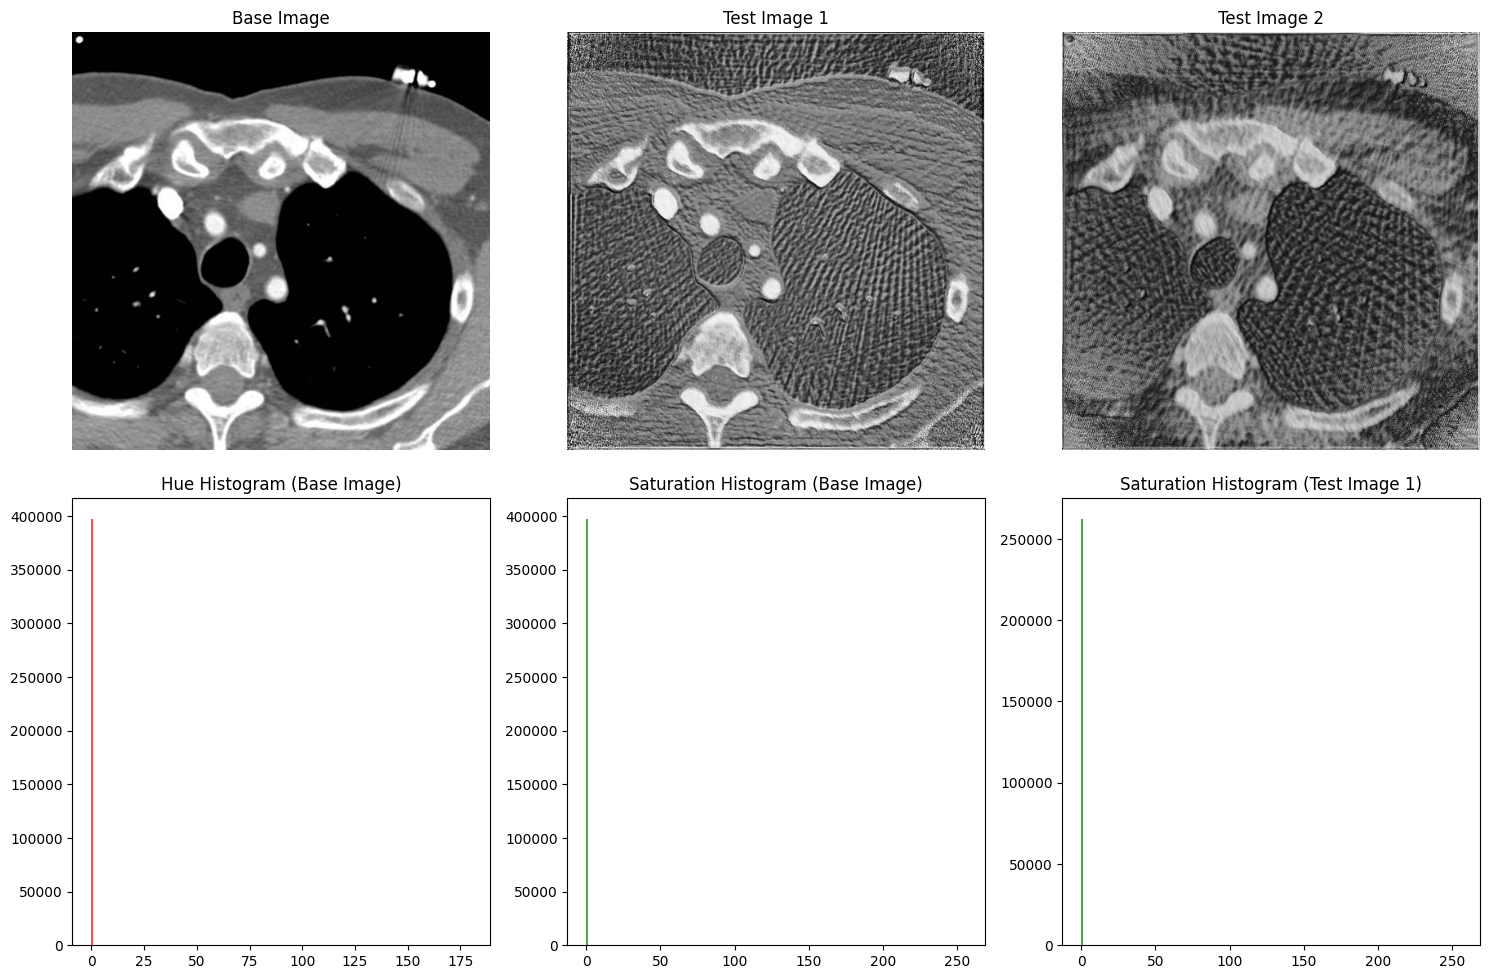

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
input1 = '/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/1.jpg'
input2 = '/content/drive/MyDrive/today output/predicted_1.jpg'
input3 = '/content/drive/MyDrive/today 3 degree output/predicted_1.jpg'

src_base = cv.imread(input1)
src_test1 = cv.imread(input2)
src_test2 = cv.imread(input3)

if src_base is None or src_test1 is None or src_test2 is None:
    print('Could not open or find the images!')
    exit(0)

# Convert to HSV
hsv_base = cv.cvtColor(src_base, cv.COLOR_BGR2HSV)
hsv_test1 = cv.cvtColor(src_test1, cv.COLOR_BGR2HSV)
hsv_test2 = cv.cvtColor(src_test2, cv.COLOR_BGR2HSV)

# Half the base image
hsv_half_down = hsv_base[hsv_base.shape[0] // 2:, :]

# Set histogram parameters
h_bins = 50
s_bins = 60
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

# Calculate histograms
hist_base = cv.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

hist_half_down = cv.calcHist([hsv_half_down], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_half_down, hist_half_down, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

hist_test1 = cv.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

hist_test2 = cv.calcHist([hsv_test2], channels, None, histSize, ranges, accumulate=False)
cv.normalize(hist_test2, hist_test2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

# Comparison Methods
comparison_methods = {
    'Correlation': cv.HISTCMP_CORREL,
    'Chi-Square': cv.HISTCMP_CHISQR,
    'Intersection': cv.HISTCMP_INTERSECT,
    'Bhattacharyya': cv.HISTCMP_BHATTACHARYYA
}

# Apply the histogram comparison methods and print the results
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Method", "Base-Base", "Base-Half", "Base-Test1", "Base-Test2"))
for method_name, method in comparison_methods.items():
    base_base = cv.compareHist(hist_base, hist_base, method)
    base_half = cv.compareHist(hist_base, hist_half_down, method)
    base_test1 = cv.compareHist(hist_base, hist_test1, method)
    base_test2 = cv.compareHist(hist_base, hist_test2, method)

    print("{:<20} {:<10} {:<10} {:<10} {:<10}".format(method_name, base_base, base_half, base_test1, base_test2))

# Visualize the images and histograms
def plot_histogram(hist, bins, title):
    # Normalize the histogram
    hist = hist / hist.sum()  # Normalize the histogram to sum to 1
    plt.plot(bins, hist, color='b', label=title)
    plt.xlim([0, 256])
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title(title)

# Set up the subplot to display images and their histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original images
axes[0, 0].imshow(cv.cvtColor(src_base, cv.COLOR_BGR2RGB))
axes[0, 0].set_title('Base Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv.cvtColor(src_test1, cv.COLOR_BGR2RGB))
axes[0, 1].set_title('Test Image 1')
axes[0, 1].axis('off')

axes[0, 2].imshow(cv.cvtColor(src_test2, cv.COLOR_BGR2RGB))
axes[0, 2].set_title('Test Image 2')
axes[0, 2].axis('off')

# Histogram plots for Hue and Saturation channels
# Hue channel histogram for Base Image
bins = np.arange(0, 181)
axes[1, 0].hist(hsv_base[:, :, 0].ravel(), bins=bins, color='r', alpha=0.7)
axes[1, 0].set_title('Hue Histogram (Base Image)')

# Saturation channel histogram for Base Image
axes[1, 1].hist(hsv_base[:, :, 1].ravel(), bins=np.arange(0, 257), color='g', alpha=0.7)
axes[1, 1].set_title('Saturation Histogram (Base Image)')

# Saturation channel histogram for Test Image 1
axes[1, 2].hist(hsv_test1[:, :, 1].ravel(), bins=np.arange(0, 257), color='g', alpha=0.7)
axes[1, 2].set_title('Saturation Histogram (Test Image 1)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, L=255, k1=0.01, k2=0.03):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        image2 = resize(image2, image1.shape, mode='reflect', anti_aliasing=True)

    # Convert images to float32 for precision in calculations
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Calculate mean values (μx, μy)
    mu_x = np.mean(image1)
    mu_y = np.mean(image2)

    # Calculate variances (σx^2, σy^2)
    sigma_x2 = np.var(image1)
    sigma_y2 = np.var(image2)

    # Calculate covariance (σxy)
    sigma_xy = np.cov(image1.flatten(), image2.flatten())[0, 1]

    # Calculate stabilizing constants (c1, c2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    # Calculate SSIM using the provided formula
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x2 + sigma_y2 + c2)

    ssim_value = numerator / denominator
    return ssim_value

# Read the images (assumed that images are grayscale .jpg files)
image1 = io.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg", as_gray=True)  # Replace with the path to the first image
image2 = io.imread("/content/drive/MyDrive/MSE, MAE loss functions/today 5 degree output/predicted_10.jpg", as_gray=True)  # Replace with the path to the second image

# Calculate SSIM
ssim_value = calculate_ssim(image1, image2)

print(f"SSIM: {ssim_value}")


SSIM: 0.9848616969326561


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/1.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/MSE/5degree/predicted_1.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.86468387836028 dB


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
    original = cv2.imread("/content/drive/MyDrive/CT_Train-20241228T165035Z-001/CT_Train/NDCT/10.jpg")
    compressed = cv2.imread("/content/drive/MyDrive/MSE/5degree/predicted_10.jpg", 1)

    # Resize compressed image to match original image dimensions
    compressed_resized = cv2.resize(compressed, (original.shape[1], original.shape[0]))

    value = PSNR(original, compressed_resized)
    print(f"PSNR value is {value} dB")

if __name__ == "__main__":
    main()


PSNR value is 27.682731133842733 dB
